# IIR migen to IIR nmigen

In this notebook, the conversion from migen to nmigen will be done.<br>
The basic file is the last one, displayed in the FIR_to_IIR.ipynb notebook<br>
At first some Includes should be changed: <br>
The other inputs are just copied.

In [14]:
from nmigen import *
from nmigen.back.pysim import *
from nmigen.cli import main
#from migen import *
#from migen.fhdl import verilog

from functools import reduce
from operator import add

from math import cos, pi
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import numpy
from scipy.signal import chirp
from scipy import signal
import scipy.signal as sig
import math

Then copy an paste the functions "minExp" and "Multiplyer" as well as the filter definition:

In [15]:
### Create the filter #######################
frequency = 100
Fs = 4800           #Sample Frequ
samples = 4800       #Number of Samples
f = 100             #Sig gen Frequ
n = 1               #Order of Filter
rs = 30             #only for Cheby
fc = 10            #Cut Frequ
w_c = 2*fc/Fs       #Digital Frequ -> 0 - 0.5
Type = "int16"      #Type of the internal calc
wsize = 16          #Wordlength
#########################################################

### Find the smallest possible Exponent out of coefa and coefb ###########
def minExp (lista,listb,maxsize):
    if maxsize == "int16":
        maxsize = 16
    elif maxsize == "int32":
        maxsize = 32
    elif maxsize == "int64":
        maxsize = 64
    else:
        raise TypeError("The Exponent must be an Integer")
    lista =  [abs(ele) for ele in lista]                            #Generates a List of absolute Values
    listb =  [abs(ele) for ele in listb]                            #Generates a List of absolute Values
    minall = min(min(lista), min(listb))                            #find the minimum of the two new lists
    maxall = max(max(lista), max(listb))                            #find the maximum of the two new lists
    Expmin = int(round(0.49 + math.log(1/minall, 2)))               #find the minimum Exponent
    Expmax = int(round(math.log((2**(maxsize-1))/maxall, 2)))       #find the maximum Exponent
    print(print("Expmin = \n", Expmin))
    print(print("Expmax = \n", Expmax))
    if Expmin > Expmax:
        raise OverflowError("Filter is not possible, enlarge the internal Register or define the specs in another way")
    return Expmin,Expmax                                            #return this two found Exponents
#########################################################################

### Used to do test for the needed Exponent##############################
def Multiplyer (coefa,coefb,Exponent):
    print(coefa,coefb)
    for c in range(len(coefa)):
        coefa[c] = np.int(coefa[c]*2**Exponent)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    coefa = coefa.astype(Type)
    print(coefa)
    for c in range(len(coefb)):
        coefb[c] = int(coefb[c]*2**Exponent)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    coefb = coefb.astype(Type)
    print(coefb)
    return coefa,coefb
########################################################################

Change the Class from "Module" to "Elaboratable"<br>
Copy and paste all the private variable definition stuff. <br>
Change all "Signal((self.wsize, True))" to "Signal(signed(self.wsize))"
Define the elaborate method <br>
Inside the elaborate method define a Module with the name m <br>
Copy and paste the rest of the filter from FIR_to_IIR.ipynb. <br>
Change all "Signal((self.wsize, True))" to "Signal(signed(self.wsize))" <br>
Change all "self.sync" to "m.d.sync" <br>
Change all "self.comb" to "m.d.comb" <br>
add a "return m" to return the module <br>



In [16]:
class iir(Elaboratable):
    def __init__(self, num,den, Exponent=16, wsize=32):     #num = coefa den = coefb
        coefa[0] = 0
        self.coefa = coefa
        self.coefb = coefb
        self.wsize = wsize
        self.i = Signal(signed(self.wsize*2))
        self.o = Signal(signed(self.wsize*2))
        self.Exponent = Exponent

        ###



    def elaborate(self, platform):
        m = Module()

        mulsb = []
        mulsa = []

        sum_fulla = Signal(signed(self.wsize*4))
        sum_fullb = Signal(signed(self.wsize*4))
        sum_full = Signal(signed(self.wsize*4))

        srcb = self.i

        for c in self.coefb:
            sregb = Signal(signed(self.wsize*2))      #Generate a new signal
            m.d.sync += sregb.eq(srcb)             #sregb = srcb
            srcb = sregb
            mulsb.append(int(c)*sregb)
        m.d.sync += sum_fullb.eq(reduce(add, mulsb))
        m.d.sync += sum_full.eq((sum_fullb-sum_fulla)>>(self.Exponent))    #Both summations are devided by Exponent

        srca = sum_full                           #the source is now the output

        for c in self.coefa:                        #same as above just with another source
            srega = Signal(signed(self.wsize*2))
            m.d.sync += srega.eq(srca)
            srca = srega
            mulsa.append(int(c)*srega)

        m.d.sync += sum_fulla.eq(reduce(add, mulsa))
        m.d.comb += self.o.eq(sum_full)

        return m

Copy and paste the first part of the main function <br>
Delete the whole iir_tb <br>
Create a simulator called "sim" which takes over the function of the test_bench "iir_tb" <br>
Like in the testbench the simulation creates a inputsignal, which is passed throug the filter. The input and the output of the filter are stored in two registers.<br>
Add the clockspeed of the simulation as well as the process, defined inside the simulator. <br>
Run the simulator with the command "sim.run"



coefa:
[ 1.         -0.98699496]
coefb:
[0.00650252 0.00650252]
Expmin = 
 8
None
Expmax = 
 15
None
[ 1.         -0.98699496] [0.00650252 0.00650252]
[-32768 -32341]
[213 213]


<ipython-input-17-35980a96ca15>:14: DeprecationWarning: instead of `with Simulator(fragment, ...) as sim:`, use `sim = Simulator(fragment); with sim.write_vcd(...):`
  with Simulator(IIR) as sim:


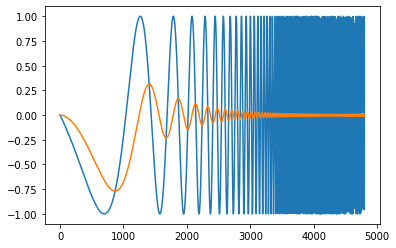

In [17]:
if __name__ == "__main__":
    [coefb,coefa] = signal.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")
    #[coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="bessel")
    print("coefa:")
    print(coefa)
    print("coefb:")
    print(coefb)
    Expmin,Expmax = minExp(coefa,coefb,Type)
    [coefa,coefb] = Multiplyer(coefa,coefb,Expmax)
    IIR = iir(coefa,coefb,Expmax,wsize)
    #crossover.plot()
    #print(crossover.polynome())

    with Simulator(IIR) as sim:
    #sim = Simulator(crossover)
        def process():
            f = 2**wsize
            input = chirp(t=numpy.linspace(0, 1, 4800), f0=1, f1=1000, t1=1, method='logarithmic',phi = 90)
            plt.plot(input)
            output = []
            for i in input:
                yield IIR.i.eq(int(i*f))
                yield Tick()
                output.append((yield IIR.o)/f)
            plt.plot(output)
            plt.show()

        sim.add_clock(1/48000)
        sim.add_process(process)
        sim.run()

# Next Step: Creating Verilog code
TBD